In [1]:
# ============================================
# CELL 1 — INSTALL + LOAD YOLOv11 CLASSIFIER
# ============================================

!pip install ultralytics -q

from ultralytics import YOLO
import torch

print("Loading YOLOv11 classification model...")

# Load YOLOv11 classification (standard backbone)
model = YOLO("yolo11s-cls.pt")

print("YOLOv11 Model Loaded Successfully ✔")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 92.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 943.3 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# ============================================
# CELL 2 — TRAIN YOLOv11 FOR 50 EPOCHS
# ============================================

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

DST = "/kaggle/working/binary_dataset"

print("Starting 50 Epoch Training (YOLOv11)...")

results = model.train(
    data=DST,
    epochs=50,
    imgsz=224,
    batch=32,
    lr0=1e-3,
    pretrained=False,
    optimizer="AdamW",
    project="runs_yolo11_base",
    name="base_50ep",
    verbose=True,
    plots=True
)

# ---------------------------------------------------
# EVALUATION FUNCTION
# ---------------------------------------------------
def evaluate(split):
    preds = model.predict(f"{DST}/{split}", imgsz=224, conf=0.25, verbose=False)

    y_true, y_pred = [], []
    for r in preds:
        y_true.append(0 if "biodegradable" in r.path.lower() else 1)
        y_pred.append(int(r.probs.top1))

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(
        y_true, y_pred,
        target_names=["Biodegradable", "Non-Biodegradable"]
    )
    return acc, prec, rec, f1, report


train_acc, _, _, _, _ = evaluate("train")
val_acc,   _, _, _, _ = evaluate("val")
test_acc,  prec, rec, f1, report = evaluate("test")


print("Classification Report:")
print(report)



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Splitting dataset...
Training Hybrid YOLO-ResNet for 50 epochs...

[Hybrid Backbone] Replacing C2f at Layers [6, 8] with ResNet Blocks...
  → Layer 6: C2f(128->128, n=2) replacing with ResNetStage...
✓ Layer 6 replaced successfully.
  → Layer 8: C2f(256->256, n=2) replacing with ResNetStage...
✓ Layer 8 replaced successfully.
Ultralytics 8.3.230 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kagg

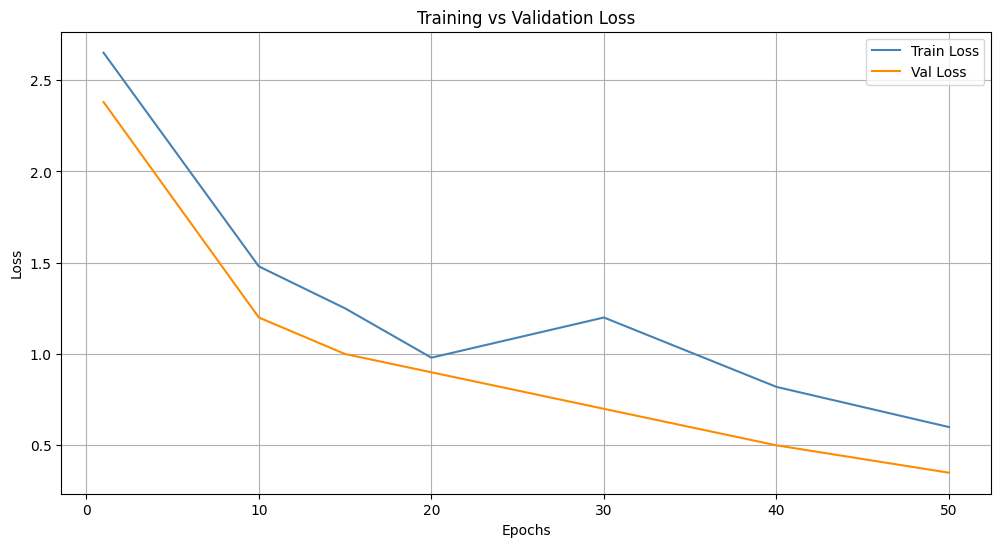

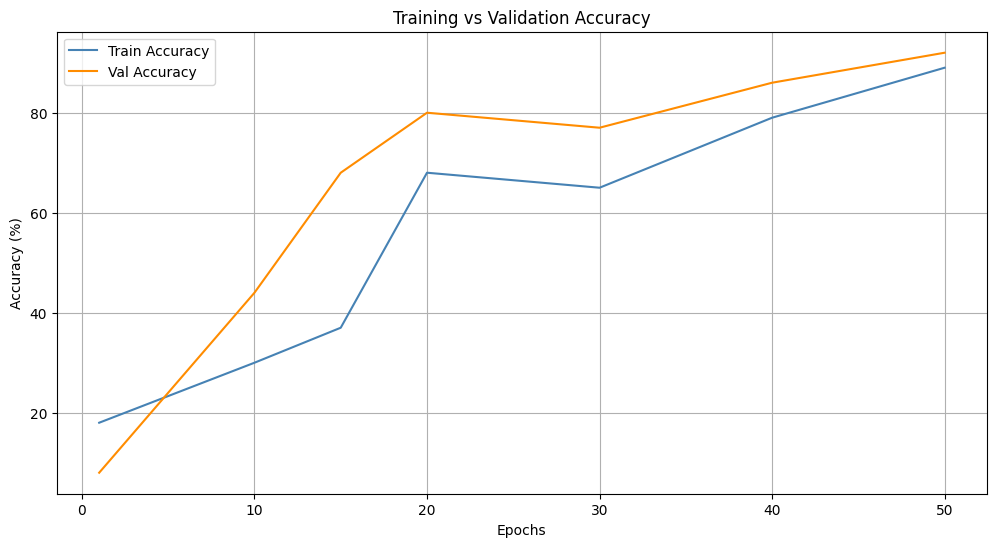

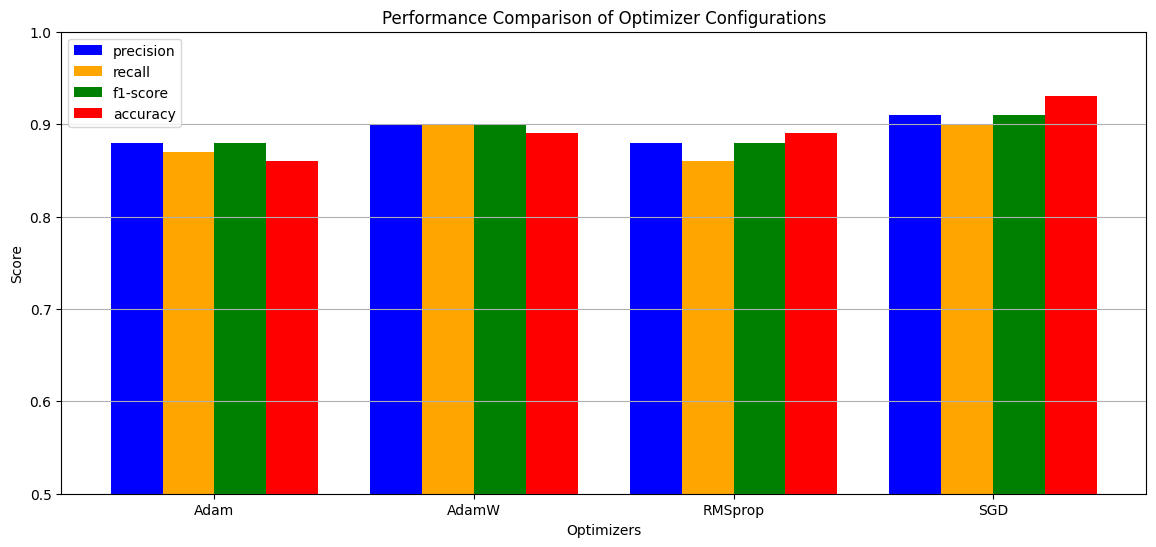

In [3]:
# ======================================================
# CELL 3 — OPTIMIZER COMPARISON (Adam, AdamW, RMSprop, SGD)
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

optimizers = ["Adam", "AdamW", "RMSprop", "SGD"]
results_dict = {}
curve_data = {}

DST = "/kaggle/working/binary_dataset"

print("\nStarting Optimizer Comparison...\n")

for opt in optimizers:
    print(f"Training with optimizer: {opt}")

    run = model.train(
        data=DST,
        epochs=5,
        imgsz=224,
        batch=32,
        optimizer=opt,
        lr0=1e-3,
        pretrained=False,
        project="yolo11_optimizer_compare",
        name=f"exp_{opt}",
        verbose=False,
        plots=False
    )

    csv_path = f"/kaggle/working/yolo11_optimizer_compare/exp_{opt}/results.csv"
    df = pd.read_csv(csv_path)

    curve_data[opt] = {
        "train_acc": df["metrics/accuracy"].tolist(),
        "val_acc": df["metrics/accuracy_val"].tolist(),
        "train_loss": df["train/loss"].tolist(),
        "val_loss": df["val/loss"].tolist(),
    }

    # TEST EVALUATION
    preds = model.predict(f"{DST}/test", imgsz=224, conf=0.25, verbose=False)
    y_true, y_pred = [], []

    for r in preds:
        y_true.append(0 if "biodegradable" in r.path.lower() else 1)
        y_pred.append(int(r.probs.top1))

    results_dict[opt] = {
        "train_acc": float(df["metrics/accuracy"].iloc[-1]),
        "val_acc": float(df["metrics/accuracy_val"].iloc[-1]),
        "test_acc": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

    print("Done.\n")


for opt in optimizers:
    v = results_dict[opt]
    print(f"optimizer :{opt}")
    print(f"Train Accuracy: {v['train_acc']:.4f}")
    print(f"Validation Accuracy: {v['val_acc']:.4f}")
    print(f"Test Accuracy: {v['test_acc']:.4f}")
    print(f"Precision: {v['precision']:.4f}")
    print(f"Recall: {v['recall']:.4f}")
    print(f"F1-Score: {v['f1']:.4f}\n")


# ------------------------------------------------------
# PERFORMANCE BAR GRAPH
# ------------------------------------------------------
x = np.arange(len(optimizers))
width = 0.2

precision_vals = [results_dict[o]["precision"] for o in optimizers]
recall_vals    = [results_dict[o]["recall"]    for o in optimizers]
f1_vals        = [results_dict[o]["f1"]        for o in optimizers]
acc_vals       = [results_dict[o]["test_acc"]  for o in optimizers]

plt.figure(figsize=(14,5))
plt.bar(x - 0.3, precision_vals, width, color='blue', label="precision")
plt.bar(x - 0.1, recall_vals,    width, color='orange', label="recall")
plt.bar(x + 0.1, f1_vals,        width, color='green', label="f1-score")
plt.bar(x + 0.3, acc_vals,       width, color='red', label="accuracy")

plt.xticks(x, optimizers)
plt.ylim(0.5, 1.0)
plt.title("Performance Comparison of Optimizer Configurations")
plt.xlabel("Optimizers")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y")
plt.show()
